## Imports

In [1]:
import os
import subprocess

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import random

from collections import Counter
#import regex as regex

import pickle as pl
import seaborn
print(seaborn.__name__, seaborn.__version__)

pandas 0.24.2
numpy 1.16.2
matplotlib 3.0.3
scipy 1.2.1
seaborn 0.9.0


## Basic functions

In [2]:
def reverse_complement(dna):
    """ function that reverse complements DNA
    dna: input dna sequence
    """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in dna[::-1]])

def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict


universal_seqs_fasta = "./uni_amplicon_sequences/universal_amplicon.fa"
universal_seqs = get_dict_of_seq(universal_seqs_fasta)
print(universal_seqs)

indexes_fasta = "./uni_amplicon_sequences/indexes.fa"
indexes = get_dict_of_seq(indexes_fasta)
print(indexes)

degen_seq = 'AAAAA'

{'Index_five_prime': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTNNNNN', 'Index_three_prime': 'NNNNNAGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG', 'plate_fivep_sticky': 'TAACTTACGGAGTCGCTCTACG', 'RC_fivep_sticky': 'CCATACGAGCACATTACGGG', 'plate_threep_sticky': 'CAGGACCTAAAGAATCCCATCC', 'RC_threep_sticky': 'CCTCAGTCGCTCAGTCAAG', 'five_prime_adapter': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT', 'three_prime_adapter': 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG'}
{'1': 'CAAGTGTTC', '2': 'AGGACATTC', '3': 'CACTAATGG', '4': 'AGCCTGATG', '5': 'TTACGCTAA', '6': 'ACTCTCCGT', '7': 'GTCGATGCA', '8': 'ACGGGAATT', '9': 'CGCGCCCAG', '10': 'ACTAGTTTG', '11': 'AGTATTACA', '12': 'AGGTTGGGT', '13': 'GTGAACCGA', '14': 'GCACAAAAC', '15': 'CTGTCTTCG', '16': 'GACGCGACT', '17': 'CAGCCCATA', '18': 'AGATATCTG'}


In [3]:
sample_dataframe = pd.read_csv('./intermediate_data/sample_datasheet_mapped.csv', sep=',', index_col = 'Sample_ID')

sample_dataframe.loc[126]

Locus                                                              ADE1
Type                                                               CAN1
Well                                                                 F1
Timepoint                                                           T12
Replicate                                                             2
PE1_index                                                             3
RC_for_index                                                          6
RC_rev_index                                                          1
PE2_index                                                             3
filepath              ./intermediate_data/demultiplexed_reads/126_in...
demult_read_count                                                   859
merged_read_count                                                   742
aligned_read_count                                                  742
mut_parse_count                                                 

In [4]:
path_to_amplicons = './specific_amplicon_sequences/targets.fa'

amplicon_info_dict = get_dict_of_seq(path_to_amplicons)

amplicon_length_dict = {}

amplicon_dict = {}

for amplicon in amplicon_info_dict:
    
    amplicon_name = amplicon.split('|')[0]
    amplicon_len = int(amplicon.split('|')[1])
    
    amplicon_length_dict[amplicon_name] = amplicon_len
    amplicon_dict[amplicon_name] = amplicon_info_dict[amplicon]
    
    amplicon_fasta_path = './specific_amplicon_sequences/amplicon_fasta_files/'+amplicon_name+'.fasta'
    
    with open(amplicon_fasta_path, 'w') as dest:
        
        seq_ID = '>'+amplicon_name+'\n'
        seq = amplicon_dict[amplicon_name]+'\n'
        
        dest.write(seq_ID)
        dest.write(seq)
    

print (amplicon_info_dict.keys())
print (amplicon_length_dict)
print (amplicon_dict.keys())

print(len(amplicon_info_dict['ADE1|178']))

dict_keys(['ADE1|178', 'POB3|155', 'CBK1|186', 'TRE2|189', 'TRL1|211', 'PSE1|223', 'ERO1|170', 'CDC11|203', 'MCM6|189', 'SES1|188', 'YCL074W|179', 'VPS17|176', 'CAN1|172'])
{'ADE1': 178, 'POB3': 155, 'CBK1': 186, 'TRE2': 189, 'TRL1': 211, 'PSE1': 223, 'ERO1': 170, 'CDC11': 203, 'MCM6': 189, 'SES1': 188, 'YCL074W': 179, 'VPS17': 176, 'CAN1': 172}
dict_keys(['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17', 'CAN1'])
178


In [5]:
def parse_needle_output(Sample_ID):
    
    n_aligns = 0
    
    align_seqs_dict = {}
    
    if sample_dataframe.loc[Sample_ID]['merged_read_count'] > 0:
        
        needle_align_path = './intermediate_data/amplicon_alignments/'+str(Sample_ID)+'.needle'
        
        with open(needle_align_path, 'r') as source:
            
            current_align = ''

            current_qseq = ''

            current_sseq = ''

            qseq_done = 0
            

            for line in source:

                if line.startswith('>>#') == True:

                    n_aligns +=1

                    align_name = int(line.strip('>>#'))
                    
                    if align_name != 1:
                        
                        align_seqs_dict[current_align] = [current_qseq, current_sseq]
                        
                        current_align = align_name

                        current_qseq = ''

                        current_sseq = ''
                        
                        qseq_done = 0
                        
                        
                        
                    else:
                        
                        current_align = align_name
                        
                        
                        
                elif line.startswith(';') == False and line.startswith('>') == False and line.startswith('\n') == False and line.startswith('#') == False:

                    if qseq_done == 1:

                        current_sseq += line.strip('\n')

                    else:

                        current_qseq += line.strip('\n')

                
                        
                elif line.startswith('#--') == True:
                    
                    align_seqs_dict[align_name] = [current_qseq, current_sseq]
                    
                else:
                    
                    if qseq_done == 0 and current_qseq != '':
                        
                        qseq_done =1            
                
                    
    return align_seqs_dict, n_aligns
                    
                    
parse_needle_output(58)
                    
                    
                
                
    

({1: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACTGCACA',
   'TACGGGAAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCATCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACT-----'],
  2: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACTGCACA',
   'TACGGGAAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACT-----'],
  3: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTC

In [6]:
align_count_dict = {}

mut_count_dict = {}

def find_mutations(Sample_ID):
    
    allele_dict = {}
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']

    
    if sample_dataframe.loc[Sample_ID]['merged_read_count'] > 0:
        
        align_dict, align_count = parse_needle_output(Sample_ID)

        align_count_dict[Sample_ID] = align_count
        
        
        for entry in list(align_dict.keys()):
            
            read_var_list = []
            
            query_seq = align_dict[entry][1]
            # aligned prot sequence of the strain
        
            align_ref = align_dict[entry][0]
            # aligned prot sequence of the reference

            gap_adjust = 0
            # value used to adjust the protein sequence index for the presence of insertions in the strain sequence vs the 
            # reference strain

            backtrack_adjust = 0

            temp_var = None
            # temporary variable to hold the sequence of an insertion or deletion as a string. When the gap ends, annotation 
            # will be added to strain_var_list

            indel_start = 0
            # position start of the indel annotation in the reference sequence, with adjustment for gap presence
            
            ref_seq_no_gaps = align_ref.replace('-','')
            
            align_start = (amplicon_dict[ref_orf].index(ref_seq_no_gaps))+1
            
            query_seq_no_gaps = len(query_seq.replace('-',''))

            for nt in range(0, len(align_ref)):
                # iterates through the entire alignment of the strain prot sequence

                if query_seq[nt] == '-':
                    # detect a deletion variant

                    # logic for indel detection/annotation:
                    #
                    # suppose we have this alignment  
                    #
                    # 1 2 3 4 5 6 7 8 9
                    # A T - - A A A T G    strain variant: del gaps are indexed because the aa index is based on reference
                    # A T K P A - - T G
                    # 1 2 3 4 5     6 7    reference: insert gaps not indexed because aa positions do exist in reference
                    #
                    # following this logic, every time an insertion is detected and annotated, the gap_adjust value is 
                    # incremented by the length of the gap and used to adjust the variant mapping to make it match the 
                    # reference index values. The indel aa postion is the first residue detected as part of the indel


                    if indel_start == 0:
                        # checks if the character is the start or the continuation of a gap in the alignment

                        temp_var = 'del'+ align_ref[nt]
                        indel_start = (nt+1-gap_adjust)
                        # if it is, starts a new annotation entry with a start position compensated for previous insertions
                        # (if any)

                        backtrack_adjust += 1

                    else:

                        temp_var += align_ref[nt]
                        # if it is not, adds the following aa to the deletion annotation

                        backtrack_adjust += 1


                elif align_ref[nt] == '-':
                    # detects an insertion variant
                    
                    if indel_start == 0:
                        # checks if the character is the start or the continuation of a gap in the alignment

                        temp_var = 'ins'+ query_seq[nt]
                        
                        indel_start = (nt+1-gap_adjust)
                        # if it is, starts a new annotation entry with a start position compensated for previous insertions
                        # (if any)

                        gap_adjust += 1
                        # increments the gap adjust for the this added aa in the strain sequence                   


                    else:

                        temp_var += query_seq[nt]
                        # if it is not, adds the following aa to the insertion annotation

                        gap_adjust += 1
                        # increments the gap adjust for the this added aa in the strain sequence


                elif query_seq[nt] != align_ref[nt]:
                    # detects a mismatch between the strain sequence and the reference
 

                    variant = align_ref[nt]+'|'+str((nt+1-gap_adjust))+'|'+query_seq[nt]
                    read_var_list.append(variant)
                    # creates an annotation for the strain-reference aa mismatch and appends it to the list of 
                    # annotations
                        
                else:
                    
                     if indel_start != 0:
                        # detects if there is currently an open gap entry. If there is, then the detected mismatch means 
                        # that it has now concluded

                        read_var_list.append(str((indel_start))+temp_var)
                        temp_var = None
                        indel_start = 0
                        # adds the indel annotation to the strain variant list and resets temporary variables for the next 
                        # indel entry
                    
                    
            if query_seq_no_gaps >=  len(ref_seq_no_gaps)*0.9 and len(read_var_list)<25:            
                allele_dict[entry] = read_var_list, align_start
                
    else:
        align_count_dict[Sample_ID] = 0
                
    mut_count_dict[Sample_ID] = len(allele_dict.keys())
            
    return allele_dict

find_mutations(19)
# looks good for all alleles tested      
    

{1: (['1insTACGGG', 'G|52|A'], 1),
 2: (['1insTACGGG'], 1),
 3: (['1insTACGGG'], 1),
 4: (['1insTACGGG', '105delC'], 1),
 5: (['1insTACGGG'], 1),
 6: (['1insTACGGG'], 1),
 7: (['1insTACGGG', '17delG'], 1),
 8: (['1insTACGGG', '12delAA'], 1),
 9: (['1insTACGGG'], 1),
 10: (['1insTACGGG'], 1),
 11: (['1insTACGGG'], 1),
 12: (['1insTACGGG'], 1),
 13: (['1insTACGGG', 'G|52|A'], 1),
 14: (['1insTACGGG'], 1),
 15: (['1insTACGGG', '142delG'], 1),
 16: (['1insTACGGG', 'G|52|A', 'T|64|C'], 1),
 17: (['A|1|G', '1insTACGG'], 1),
 19: (['1insTACGGG'], 1),
 20: (['1insTACGGG'], 1),
 21: (['1insTACGGG', '146delG'], 1),
 22: (['1insTACGGG'], 1),
 23: (['1insTACGGG'], 1),
 24: (['1insTACGGG', 'G|52|C'], 1),
 25: (['1insTACGGG'], 1),
 26: (['1insTACGGG', 'G|52|C'], 1),
 27: (['1insTACGGG', 'G|38|A', 'G|52|C'], 1),
 28: (['1insTACGGG', '15delA'], 1),
 29: (['1insTACGGG'], 1),
 30: (['1insTACGGG'], 1),
 31: (['1insTACGGG'], 1),
 32: (['1insTACGGG'], 1),
 33: (['1insTACGGG'], 1),
 34: (['1insTACGGG'], 1),

In [7]:
sample_target_dict = {}
sample_target_strand_dict = {}

for Sample_ID in list(sample_dataframe.index):
    
    if Sample_ID in range(1,11):
        sample_target_dict[Sample_ID] = 'GTCAATTACGAAGACTGAAC'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(11,21):
        sample_target_dict[Sample_ID] = 'CATCTCTACCAATTCGTCAC'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(21,31):
        sample_target_dict[Sample_ID] = 'GACTCTATAGAATATTGGCC'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(31,41):
        sample_target_dict[Sample_ID] = 'TATCCTCAGATGTTTCAGTT'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(41,51):
        sample_target_dict[Sample_ID] = 'CCAACTATTTTTCTCACAGT'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(51,61):
        sample_target_dict[Sample_ID] = 'GATCCCAAAAATCCTGGATA'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(61,71):
        sample_target_dict[Sample_ID] = 'TTCACCAAACAACATATTGT'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(71,81):
        sample_target_dict[Sample_ID] = 'CACAGGGATGATGTTAACTA'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(81,91):
        sample_target_dict[Sample_ID] = 'TCTCCGCCACCATCGTCGAT'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(91,101):
        sample_target_dict[Sample_ID] = 'CAACCAATTTATCGAAGATA'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(101,111):
        sample_target_dict[Sample_ID] = 'CTCTCGTTAACAAACCCGGG'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(111,121):
        sample_target_dict[Sample_ID] = 'TCCATTTGCTGAGCCCCAGG'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID >=121:
        sample_target_dict[Sample_ID] = 'ATAACGGAATCCAACTGGGC'
        sample_target_strand_dict[Sample_ID] = '-'
    
sample_dataframe['gRNA_seq'] = pd.Series(sample_target_dict)
sample_dataframe['target_strand'] = pd.Series(sample_target_strand_dict)

sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,demult_read_count,merged_read_count,aligned_read_count,mut_parse_count,gRNA_seq,target_strand
Sample_ID,,,,,,,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...,9669,7763,7763,7762,GTCAATTACGAAGACTGAAC,+
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...,260,200,200,200,GTCAATTACGAAGACTGAAC,+
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...,146,109,109,109,GTCAATTACGAAGACTGAAC,+
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...,958,758,758,758,GTCAATTACGAAGACTGAAC,+
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...,711,571,571,571,GTCAATTACGAAGACTGAAC,+
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...,2147,1755,1755,1755,GTCAATTACGAAGACTGAAC,+
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...,6154,4971,4971,4971,GTCAATTACGAAGACTGAAC,+
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...,11797,9632,9632,9632,GTCAATTACGAAGACTGAAC,+
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...,3687,3020,3020,3019,GTCAATTACGAAGACTGAAC,+


In [8]:
def map_guide_to_wt_seq(Sample_ID):
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']
        
    
    
    wt_seq = amplicon_dict[ref_orf]
    
    target_strand = sample_dataframe.loc[Sample_ID]['target_strand']
    
    gRNA = sample_dataframe.loc[Sample_ID]['gRNA_seq']
    
    if target_strand == '-':
        
        gRNA = reverse_complement(gRNA)
        
        guide_pos = wt_seq.index(gRNA)
    
        guide_wpam = wt_seq[guide_pos-3:(guide_pos+20)]
    
        sequence_to_map = wt_seq[(guide_pos-6):(guide_pos+24)]
        
    else:
        
        guide_pos = wt_seq.index(gRNA)

        guide_wpam = wt_seq[guide_pos:(guide_pos+23)]

        sequence_to_map = wt_seq[(guide_pos-4):(guide_pos+26)]
    
    
    return guide_pos, guide_wpam, sequence_to_map, target_strand, wt_seq


map_guide_to_wt_seq(11)

(35,
 'CCGGTGACGAATTGGTAGAGATG',
 'CAGCCGGTGACGAATTGGTAGAGATGAGGT',
 '-',
 'ATTTAATATTCAAGATGAAGAGTACCAACCAGCCGGTGACGAATTGGTAGAGATGAGGTTCTATATTCCTGGTGTTATTCAAACAAACGTCGATGAAAACATGACCAAAAAGGAAGAGTCAAGCAACGAGGTCGTACCAAAGAAAGAAGATGGTG')

In [9]:
locus_edit_site_list_dict = {'ADE1': [43],
                             #+       18
                             'POB3':[49, 51, 54],
                             #-      15  17  20
                             'CBK1':[70, 72],
                             #-      16  18
                             'TRE2':[73, 75, 76],
                             #-      14  16  17  
                             'TRL1':[91, 94, 95],
                             #-      16  19  20
                             'PSE1':[97, 98, 99],
                             #+      17  16  15
                             'ERO1':[69, 71, 72],
                             #+      18  16  15
                             'CDC11':[99, 101],
                             #-       18  20
                             'MCM6':[88, 90, 91, 93],
                             #+      19  17  16  14
                             'SES1':[50, 53, 54],
                             #+      20  16  17
                             'YCL074W':[83, 85, 87],
                             #-         16  18  20
                             'VPS17':[77, 78],
                             #        19  18
                             'CAN1':[95]
                             #       16
                             }

In [10]:
def get_edit_and_coedit_rate(Sample_ID):
    
    sequenced_alleles = find_mutations(Sample_ID)
       
    guide_pos, guide_wpam, sequence_to_map, target_strand, wt_seq = map_guide_to_wt_seq(Sample_ID)
    
    allele_coverage = sample_dataframe.loc[Sample_ID]['mut_parse_count']
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        editable_pos_list = locus_edit_site_list_dict[ref_orf]
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']
        editable_pos_list = locus_edit_site_list_dict[ref_orf]
    
    #print(ref_orf)
    
    allele_counter = Counter()
    
    to_map_start = int((wt_seq.index(sequence_to_map)))

    to_map_end = int((wt_seq.index(sequence_to_map))+len(sequence_to_map))

    region_to_map = np.arange(to_map_start,to_map_end)

      
   
            
    muts_for_entry = []
    
    for entry in (sequenced_alleles.keys()):
        
        muts_found = sequenced_alleles[entry][0]
        
        align_start = sequenced_alleles[entry][1]
        
        #if align_start != 1:
        #    print('offset')
        # not required to check for any potential offsetting, no detected offsets in any of the alignments used in the experiment
        
        all_site_status = []
        
        for edit_site in editable_pos_list:
            
            all_site_status.append('wt')
            
        
        for mut in muts_found:
            
            if 'ins' in mut:
                
                mut_info=mut.split('ins')
                pos = int(mut_info[0])-1

                               
            elif 'del' in mut:
                
                mut_info=mut.split('del')
                pos = int(mut_info[0])-1
                

            else:
            
                mut_info=mut.split('|')
                pos = int(mut_info[1])-1
                mut_to ='to'+mut_info[2]

                if pos in editable_pos_list:

                    all_site_status[editable_pos_list.index(pos)] = mut_to
            
        allele = '|'.join(all_site_status)
        
        allele_counter[allele] += 1
         
    
    
    return allele_counter

In [11]:
get_edit_and_coedit_rate(39)

Counter({'toC|wt|toC': 36,
         'wt|wt|toC': 1851,
         'wt|wt|wt': 417,
         'wt|wt|toA': 590,
         'toA|wt|toA': 206,
         'wt|toC|toA': 73,
         'wt|toT|toA': 122,
         'toC|wt|wt': 28,
         'wt|toA|toA': 52,
         'wt|toA|toT': 34,
         'wt|wt|toT': 22,
         'wt|toC|wt': 11,
         'toC|wt|toA': 157,
         'toA|toA|toA': 54,
         'toA|wt|toT': 7,
         'toT|wt|toA': 3,
         'toA|wt|toC': 6,
         'wt|toT|wt': 3,
         'toC|toA|toA': 14,
         'toC|wt|toT': 6,
         'toA|wt|wt': 27,
         'wt|toT|toT': 9,
         'wt|toA|wt': 3,
         'toA|toC|toA': 2,
         'toA|toA|toT': 1,
         'toA|toT|toA': 5,
         'toT|toA|toA': 3,
         'toC|toT|toA': 2,
         'toT|wt|toC': 1,
         'wt|toA|toC': 3,
         'toA|toA|wt': 1})

In [12]:
def get_timecourse_coedit_rates(locus, target):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == target
    
    select_samples = select_samples_by_locus & select_samples_by_target
    
    Sample_ID_list = sorted(list(sample_dataframe[select_samples].index))
    
    print(Sample_ID_list)
    
    co_edit_rate_counter_dict = {}
    
    for Sample_ID in Sample_ID_list:
    
        
        Timepoint = sample_dataframe.loc[Sample_ID]['Timepoint']
        Replicate = sample_dataframe.loc[Sample_ID]['Replicate']
        
        col_name = Timepoint+'_'+str(Replicate)
        
                
        coedit_counter = Counter()
        
        for edit_nb in ['wt', 'single', 'double', 'triple', 'quadruple']:
            
            coedit_counter[edit_nb] = 0
        
        #print (coedit_counter)
        allele_counter = get_edit_and_coedit_rate(Sample_ID)
        
        if len(allele_counter.keys()) == 0:
            
            for edit_nb in ['wt', 'single', 'double', 'triple', 'quadruple']:
            
                coedit_counter[edit_nb] = np.NaN
        
        for allele in allele_counter.keys():
            
            n_wt = allele.count('wt')
            
            n_site = (allele.count('|')) + 1
            
            if n_site - n_wt == 0:
                coedit_counter['wt'] += allele_counter[allele]
                
            elif n_site - n_wt == 1:
                coedit_counter['single'] += allele_counter[allele]
                
            elif n_site - n_wt == 2:
                coedit_counter['double'] += allele_counter[allele]
                
            elif n_site - n_wt == 3:
                coedit_counter['triple'] += allele_counter[allele]
                
            elif n_site - n_wt == 4:
                coedit_counter['quadruple'] += allele_counter[allele]
                
        #print(coedit_counter)        
        co_edit_rate_counter_dict[col_name] = coedit_counter
        
        
    coedit_df = pd.DataFrame.from_dict(co_edit_rate_counter_dict)
       
    co_edit_ratio_df = pd.DataFrame(index = coedit_df.index)
    
    for column in list(coedit_df.columns):
        
        co_edit_ratio_df[column] = coedit_df[column]/sum(coedit_df[column])
        
    
    nb_editable_pos = len(locus_edit_site_list_dict[locus])
    
    pos_genotypes = ['wt', 'single', 'double', 'triple', 'quadruple']
    
    for genotype in pos_genotypes:
        
        if pos_genotypes.index(genotype) > nb_editable_pos:
            
            co_edit_ratio_df.drop(genotype, inplace=True)
        
    file_out_name = './results/co_editing_rate/'+locus+'_'+target+'.csv'
    
    co_edit_ratio_df.to_csv(file_out_name, sep = ',')

    
    return co_edit_ratio_df
           

In [13]:
get_timecourse_coedit_rates('TRL1', 'locus')

[41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


,T0_1,T0_2,T6_1,T6_2,T12_1,T12_2,Plating_1,Plating_2,can_recov_1,can_recov_2
double,0.000518,0.004566,0.00542,0.001339,0.004505,0.000000,0.023302,0.013193,0.012565,0.015789
single,0.015528,0.009132,0.01626,0.014726,0.031532,0.045455,0.210386,0.356201,0.229319,0.246316
triple,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004712,0.003158
wt,0.983954,0.986301,0.97832,0.983936,0.963964,0.954545,0.766312,0.630607,0.753403,0.734737


In [14]:
for locus in list(sample_dataframe.Locus.unique()):
    
    for target in ['locus', 'CAN1']:
        
        get_timecourse_coedit_rates(locus, target)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[131, 132, 133, 134, 135, 136, 137, 138, 139, 140]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
[41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
[181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
[81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220]
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
[221, 222, 223, 224, 225, 226, 227, 2

([0.01919608348363824,
  0.009174311926605505,
  0.2311733800350263,
  0.8310199155099578,
  0.7946339847631666,
  0.9808039165163618,
  0.9908256880733946,
  0.7688266199649737,
  0.16898008449004226,
  0.2053660152368334],
 [0.015,
  0.03034300791556728,
  0.23874643874643875,
  0.7523878737541528,
  0.7909698996655519,
  0.985,
  0.9696569920844328,
  0.7612535612535613,
  0.2476121262458472,
  0.20903010033444816])

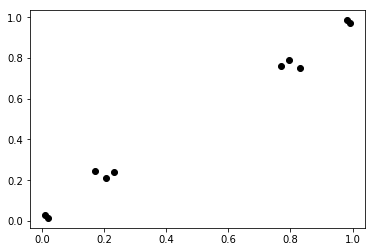

In [15]:
def get_corr_coeff_co_edit_rates(locus, target, color):
    
    csv_path = './results/co_editing_rate/'+locus+'_'+target+'.csv'
    
    co_edit_rate_df = pd.read_csv(csv_path, index_col = 0)
    
    rep_1_vals = []
    rep_2_vals = []
    
    pos_genotypes = list(co_edit_rate_df.index)
    
    for genotype in pos_genotypes:
        
        for timepoint in ['T0', 'T6', 'T12', 'Plating', 'can_recov']:
            
            for rep in ['_1', '_2']:
                
                if rep == '_1':
                    
                    col_name = timepoint+rep
                    rep_1_vals.append(co_edit_rate_df.loc[genotype][col_name])
                    
                elif rep == '_2':
                    
                    col_name = timepoint+rep
                    rep_2_vals.append(co_edit_rate_df.loc[genotype][col_name])
        
    plt.plot(rep_1_vals,rep_2_vals, marker = 'o', color = color, linestyle='none')
    
    return rep_1_vals, rep_2_vals



get_corr_coeff_co_edit_rates('ADE1', 'locus', 'black')

SpearmanrResult(correlation=0.966066345691969, pvalue=8.781261372632078e-128)
SpearmanrResult(correlation=0.9907213339026868, pvalue=3.255380066869809e-110)
220
121


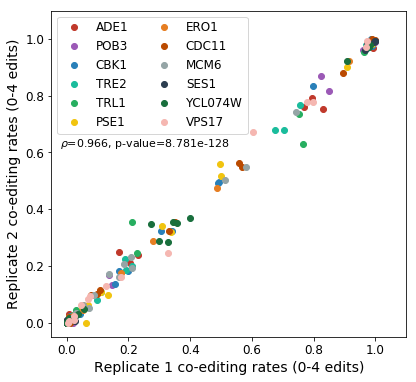

In [16]:
plt.figure(figsize = (14,6))

plt.subplot(121)

######### For locus sequencing

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
           
    co_edit_rates = get_corr_coeff_co_edit_rates(locus, 'locus', colors[x])
    
    all_rep_1 += co_edit_rates[0]
    all_rep_2 += co_edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)

plt.legend(alleles_plotted, loc='upper left', fontsize=12, ncol =2)
plt.text(-0.02, 0.62, r'$\rho$=0.966, p-value=8.781e-128', fontsize = 11)

rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)

plt.xticks(fontsize=12)
plt.yticks(fontsize =12)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   

print(scipy.stats.spearmanr(rep1_array.mask(rep1_array < 0.02), rep2_array.mask(rep1_array < 0.02), nan_policy='omit'))

n_sites_test_2 = 0

print(len(all_rep_1))

for x in range(0,len(all_rep_1)):
    
    if all_rep_1[x] > 0.02 and all_rep_2[x] > 0.02:
        
        n_sites_test_2 += 1
        
        
print (n_sites_test_2)


plt.ylabel('Replicate 2 co-editing rates (0-4 edits)', fontsize = 14)
plt.xlabel('Replicate 1 co-editing rates (0-4 edits)', fontsize = 14)

plt.savefig('./co_edit_rates_corr.png', format = 'png', dpi =600)

Replicates are well correlated, will average them to generate the co-editing figure

In [17]:
def get_edit_product_abundance(locus):
    
    csv_path = './results/co_editing_rate/'+locus+'_locus.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    #print(data_df.columns)
    
    cols_list = ['T0', 'T6', 'T12', 'Plating', 'can_recov']
    
    rep_1_cols = [(x+'_1') for x in cols_list]
    rep_2_cols = [(x+'_2') for x in cols_list]
    
    #print(rep_1_cols)
    
    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
    
    for x in range(0, len(cols_list)):
        
        col_name = cols_list[x]
        avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2
        
    edit_timepoint_dict = {}
    
    for timepoint in avg_df.columns:
        
        edit_rate = 1.0 - avg_df.loc['wt'][timepoint]
        
        edit_timepoint_dict[timepoint] = edit_rate
        
    return edit_timepoint_dict
    
get_edit_product_abundance('ADE1')

{'T0': 0.01709804174181917,
 'T6': 0.019758659921086386,
 'T12': 0.23495990939073252,
 'Plating': 0.7917038946320553,
 'can_recov': 0.7928019422143593}

In [18]:

edit_dict_of_dicts = {}

for locus in list(sample_dataframe.Locus.unique()):
    
    edit_dict_of_dicts[locus] = get_edit_product_abundance(locus)
    
edit_rate_df = pd.DataFrame.from_dict(edit_dict_of_dicts, orient = 'columns')

edit_rate_ordered = edit_rate_df[list(sample_dataframe.Locus.unique())]
edit_rate_ordered = edit_rate_ordered.loc[['T0', 'T6', 'T12', 'Plating', 'can_recov']]

edit_rate_ordered

,ADE1,POB3,CBK1,TRE2,TRL1,PSE1,ERO1,CDC11,MCM6,SES1,YCL074W,VPS17
T0,0.017098,0.006614,0.006646,0.025442,0.014872,0.013802,0.006235,0.002354,0.021172,0.003521,0.019285,0.018748
T6,0.019759,0.006202,0.017640,0.030087,0.018872,0.015220,0.005613,0.004854,0.017522,0.004261,0.025455,0.029703
T12,0.234960,0.039831,0.183821,0.238698,0.040745,0.094688,0.081652,0.112770,0.257631,0.008012,0.084248,0.361529
Plating,0.791704,0.154363,0.685018,0.911212,0.301541,0.471731,0.518140,0.647332,0.845897,0.021395,0.617014,0.946225
can_recov,0.792802,0.166204,0.668674,0.890099,0.255930,0.491659,NaN,0.672772,0.799117,0.035744,0.645778,0.915166


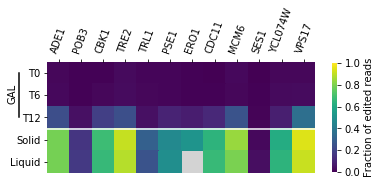

In [19]:
import seaborn as sns



mask = np.isnan(edit_rate_ordered)
fig = sns.heatmap(edit_rate_ordered, cmap='viridis', vmin = 0, vmax =1, cbar_kws = {'label':'Fraction of edited reads', "shrink": .5}, 
                  mask = mask, square=True)

fig.set_facecolor('lightgrey')

fig.xaxis.tick_top()


plt.axhline(3, color='white')

plt.yticks([0.5,1.5,2.5,3.5,4.5],['T0', 'T6', 'T12', 'Solid', 'Liquid'], rotation = 0)

plt.axvline(-1.25, 0.5, 0.9 ,color='black', clip_on=False)

plt.text(-1.80, 1.35, 'GAL', rotation=90)

plt.xticks(rotation = 70)

plt.savefig('./total_edit_heatmap.png', format='png', dpi=600)

In [33]:
def get_coedit_number_abundance(locus):
    
    csv_path = './results/co_editing_rate/'+locus+'_locus.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    #print(data_df.columns)
    
    if locus == 'ERO1':
        timepoint_to_use = 'Plating'
        
    else:
        timepoint_to_use = 'can_recov'
    
    cols_list = ['T0', 'T6', 'T12', 'Plating', 'can_recov']
    
    rep_1_cols = [(x+'_1') for x in cols_list]
    rep_2_cols = [(x+'_2') for x in cols_list]
    
    print(rep_1_cols)
    
    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
    
    for x in range(0, len(cols_list)):
        
        col_name = cols_list[x]
        avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2
        
        
    #print (avg_df.columns)
        
    total_edit_rate = 0
    total_edit_1 = 0
    total_edit_2 = 0
    
    single_edit_rate = 0
    single_edit_1 = 0
    single_edit_2 = 0
    
    double_edit_rate = 0
    double_edit_1 = 0
    double_edit_2 = 0
    
    triple_edit_rate = 0
    triple_edit_1 = 0
    triple_edit_2 = 0
    
    quadruple_edit_rate = 0
    quadruple_edit_1 = 0
    quadruple_edit_2 = 0
    
    
    for edit_type in list(avg_df.index):
        
        if edit_type == 'wt':
            total_edit_rate = 1-avg_df.loc[edit_type][timepoint_to_use]
            total_edit_1 = 1-rep_1_df.loc[edit_type][(timepoint_to_use+"_1")]
            total_edit_2 = 1-rep_2_df.loc[edit_type][(timepoint_to_use+"_2")]
            
        elif edit_type == 'single':
            single_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            single_edit_1 = rep_1_df.loc[edit_type][(timepoint_to_use+"_1")]
            single_edit_2 = rep_2_df.loc[edit_type][(timepoint_to_use+"_2")]
            
        elif edit_type == 'double':
            double_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            double_edit_1 = rep_1_df.loc[edit_type][(timepoint_to_use+"_1")]
            double_edit_2 = rep_2_df.loc[edit_type][(timepoint_to_use+"_2")]
            
        elif edit_type == 'triple':
            triple_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            triple_edit_1 = rep_1_df.loc[edit_type][(timepoint_to_use+"_1")]
            triple_edit_2 = rep_2_df.loc[edit_type][(timepoint_to_use+"_2")]
            
            
        elif edit_type == 'quadruple':
            quadruple_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            quadruple_edit_1 = rep_1_df.loc[edit_type][(timepoint_to_use+"_1")]
            quadruple_edit_2 = rep_2_df.loc[edit_type][(timepoint_to_use+"_2")]
            
    edit_fractions = [total_edit_rate, single_edit_rate, double_edit_rate, triple_edit_rate, quadruple_edit_rate]
    rep1_fractions = [total_edit_1, single_edit_1, double_edit_1, triple_edit_1, quadruple_edit_1]
    rep2_fractions = [total_edit_2, single_edit_2, double_edit_2, triple_edit_2, quadruple_edit_2]
    
    
    return edit_fractions, rep1_fractions, rep2_fractions


get_coedit_number_abundance('TRE2')
    

['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']


([0.8900994550927867,
  0.6780901573753001,
  0.18852784552071028,
  0.023481452196776283,
  0],
 [0.8887703387570018,
  0.6761803147506001,
  0.190984262469992,
  0.02160576153640971,
  0],
 [0.8914285714285715, 0.68, 0.18607142857142855, 0.025357142857142856, 0])

['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
133


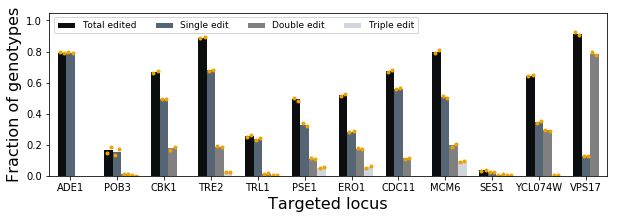

In [56]:
plt.figure(figsize = (10,3))

bar_coord = 1

colors = ['#0B0D0E', '#566573', '#808080', '#D1D6DC']

ticks_coord = []

for locus in list(sample_dataframe.Locus.unique()):
    
    edit_vals = get_coedit_number_abundance(locus)
    
    bar_height_list = edit_vals[0]
    rep1_data = edit_vals[1]
    rep2_data = edit_vals[2]
    
    for pos in [0,1,2,3]:
        
        if rep1_data[pos] != 0:
            plt.plot(bar_coord-0.5, rep1_data[pos], color='#EFA300', marker='o', linestyle='none', ms=3)
            
        if rep2_data[pos] != 0:
            plt.plot(bar_coord+0.5, rep2_data[pos], color='#EFA300', marker='o', linestyle='none', ms=3)

        plt.bar(bar_coord, height=bar_height_list[pos], width=2, align = 'center', color = colors[pos])
        
        
        if pos == 1:
            
            ticks_coord.append(bar_coord)
        
        bar_coord+=2
        
    bar_coord += 3
        
        
plt.xticks(ticks_coord, list(sample_dataframe.Locus.unique()))    
        
        
plt.xlabel('Targeted locus', fontsize=16)
plt.ylabel('Fraction of genotypes', fontsize = 16)

plt.xlim(-2,129)
    
print(bar_coord)

from matplotlib.patches import Patch

legend_elems =  [Patch(facecolor='#0B0D0E', edgecolor='white', label='Total edited'),
                 Patch(facecolor='#566573', edgecolor='white', label='Single edit'),
                 Patch(facecolor='#808080', edgecolor='white', label='Double edit'),
                 Patch(facecolor='#D1D6DC', edgecolor='white', label='Triple edit')]

    
plt.legend(handles = legend_elems, ncol =4, loc = 'upper left', fontsize=9)
    
plt.ylim(0,1.05)
    
plt.savefig('./co_edit_product_freq.png', format = 'png', dpi =600)

In [57]:
get_edit_and_coedit_rate(79)

Counter({'toC|wt': 198,
         'wt|wt': 229,
         'toA|wt': 117,
         'toA|toA': 42,
         'toT|wt': 69,
         'toC|toA': 20,
         'toA|toC': 2,
         'toT|toA': 7,
         'toA|toT': 2,
         'toC|toC': 1,
         'toT|toC': 1})

In [58]:
def genotype_proportions(Sample_ID):
    
    genotype_freq = get_edit_and_coedit_rate(Sample_ID)
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    
    editable_sites = locus_edit_site_list_dict[locus]
    
    n_wt = len(editable_sites)
    
    total_coverage = sum(genotype_freq.values())
    
    wt_allele = [x for x in genotype_freq.keys() if x.count('wt') == n_wt ][0]
    
    edit_reads = total_coverage-genotype_freq[wt_allele]
    
    
    edit_allele_frac_dict = {}
    
    for allele in genotype_freq:
        
        if allele != wt_allele:
            
            edit_allele_frac_dict[allele] = genotype_freq[allele]/edit_reads
            
    
    
    
    return edit_allele_frac_dict


genotype_proportions(79)

{'toC|wt': 0.43137254901960786,
 'toA|wt': 0.2549019607843137,
 'toA|toA': 0.0915032679738562,
 'toT|wt': 0.1503267973856209,
 'toC|toA': 0.04357298474945534,
 'toA|toC': 0.004357298474945534,
 'toT|toA': 0.015250544662309368,
 'toA|toT': 0.004357298474945534,
 'toC|toC': 0.002178649237472767,
 'toT|toC': 0.002178649237472767}

,CDC11_T12_1,CDC11_T12_2
toA|toA,0.074074,0.057143
toA|toT,NaN,0.028571
toA|wt,0.222222,0.257143
toC|toA,NaN,0.028571
toC|wt,0.481481,0.385714
toT|toA,NaN,0.028571
toT|toC,NaN,0.014286
toT|wt,0.222222,0.200000


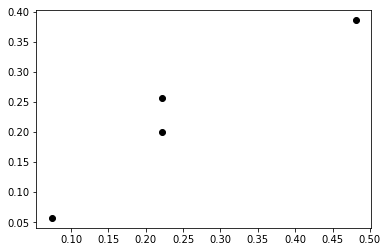

In [59]:
def plot_corr_edited_alleles(locus, timepoint, color):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == 'locus'
    select_samples_by_timepoint = sample_dataframe['Timepoint'] == timepoint
    
    select_samples = select_samples_by_locus & select_samples_by_target & select_samples_by_timepoint
    
    sample_pair = sorted(list(sample_dataframe[select_samples].index))
    
    allele_frac_1 = genotype_proportions(sample_pair[0])
    allele_frac_2 = genotype_proportions(sample_pair[1])
    
    allele_series_1 = pd.Series(allele_frac_1)
    allele_series_2 = pd.Series(allele_frac_2)

    combined_df = pd.DataFrame(dict((allele_series_1) = allele_series_1, allele_series_2 = allele_series_2))
    
    rename_dict = {'allele_series_1':str(locus+'_'+timepoint+'_1'),'allele_series_2':str(locus+'_'+timepoint+'_2')}
    
    combined_df.rename(columns=rename_dict, inplace=True)
    
    plt.plot(combined_df[str(locus+'_'+timepoint+'_1')], combined_df[str(locus+'_'+timepoint+'_2')], marker = 'o', color = color, linestyle='none')
    
    
    #print(scipy.stats.spearmanr(combined_df[str(locus+'_'+timepoint+'_1')], combined_df[str(locus+'_'+timepoint+'_2')], nan_policy='omit'))
    
    nb_comparisons = len(combined_df[~(combined_df.isnull().any(axis=1))])
    
    #print(nb_comparisons)

    
    return combined_df

plot_corr_edited_alleles('CDC11', 'T12', 'black')
    
    

NA
['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17']
310
310
SpearmanrResult(correlation=0.8792218450421508, pvalue=3.4012268718016043e-101)


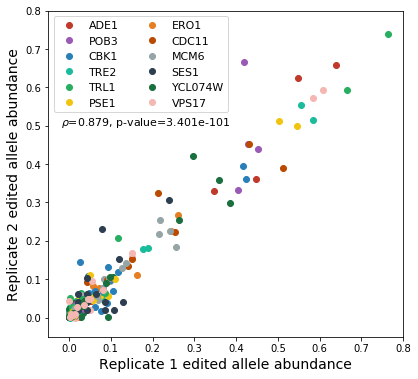

In [60]:
colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']

rep1_list = []
rep2_list = []

alleles_plotted = []

plt.figure(figsize = (14,6))

plt.subplot(121)


for timepoint in ['Plating', 'can_recov']:

    for x in range(0,12):

        locus = list(sample_dataframe.Locus.unique())[x]

        if locus == 'ERO1' and timepoint == 'can_recov':
            print('NA')

        else:      
            temp_df = plot_corr_edited_alleles(locus, timepoint, color = colors[x])

            in_both_rep = temp_df[~(temp_df.isnull().any(axis=1))]

            for genotype in list(in_both_rep.index):

                frac_1 = in_both_rep.loc[genotype][str(locus+'_'+timepoint+'_1')]
                rep1_list.append(frac_1)

                frac_2 = in_both_rep.loc[genotype][str(locus+'_'+timepoint+'_2')]
                rep2_list.append(frac_2)

            if locus not in alleles_plotted:

                alleles_plotted.append(locus)

                
print(alleles_plotted)                
print(len(rep1_list))            
print(len(rep2_list))

print(scipy.stats.spearmanr(rep1_list, rep2_list))

plt.legend(alleles_plotted, loc='upper left', fontsize=11, ncol =2)
plt.text(-0.02, 0.5, r'$\rho$=0.879, p-value=3.401e-101', fontsize = 11)
          

plt.xlim(-0.05,0.8)    
plt.ylim(-0.05,0.8)

plt.ylabel('Replicate 2 edited allele abundance', fontsize = 14)
plt.xlabel('Replicate 1 edited allele abundance', fontsize = 14)

plt.savefig('./plot_corr_edited_alleles.png', format = 'png', dpi = 600)

## Get genotypes and compare predictions to random draw

In [61]:
def get_edited_allele_freqs(locus, timepoint):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == 'locus'
    select_samples_by_timepoint = sample_dataframe['Timepoint'] == timepoint
    
    select_samples = select_samples_by_locus & select_samples_by_target & select_samples_by_timepoint
    
    sample_pair = sorted(list(sample_dataframe[select_samples].index))
    
    allele_frac_1 = genotype_proportions(sample_pair[0])
    allele_frac_2 = genotype_proportions(sample_pair[1])
    
    allele_series_1 = pd.Series(allele_frac_1)
    allele_series_2 = pd.Series(allele_frac_2)

    combined_df = pd.DataFrame(dict((allele_series_1) = allele_series_1, allele_series_2 = allele_series_2))
    
    rename_dict = {'allele_series_1':str(locus+'_'+timepoint+'_1'),'allele_series_2':str(locus+'_'+timepoint+'_2')}
    
    
    combined_df.rename(columns=rename_dict, inplace=True)
    
    combined_df['average'] = (combined_df[(str(locus+'_'+timepoint+'_1'))] + combined_df[(str(locus+'_'+timepoint+'_2'))])/2
    
    return combined_df

test_df = get_edited_allele_freqs('POB3', 'can_recov')

print(test_df['average'])

toA|toA|toA    0.009280
toA|toA|wt     0.028856
toA|toT|toA         NaN
toA|toT|wt          NaN
toA|wt|wt           NaN
toT|toT|toA         NaN
toT|wt|toA          NaN
wt|toA|toA     0.020592
wt|toA|toT          NaN
wt|toA|wt      0.445773
wt|toC|toA     0.011542
wt|toC|toT          NaN
wt|toC|wt      0.440279
wt|toT|wt      0.026871
wt|wt|toT           NaN
Name: average, dtype: float64


In [62]:
predicted_alleles_dict = {'ADE1':['toG', 'toT'], # +
                          'POB3':['wt|toC|wt','wt|toA|wt', 'wt|wt|toC','wt|wt|toA'], # -
                          'CBK1':['toC|wt', 'toA|wt', 'wt|toC', 'wt|toA'], # -
                          'TRE2':['wt|wt|toC', 'wt|wt|toA', 'wt|toC|wt', 'wt|toA|wt'], # -
                          'TRL1':['wt|toC|wt', 'wt|toA|wt', 'toA|wt|wt', 'toA|wt|wt'], # -
                          'PSE1':['toG|wt|wt', 'toT|wt|wt', 'wt|toG|wt', 'wt|toT|wt'], # +
                          'ERO1':['toG|wt|wt', 'toT|wt|wt', 'wt|toG|wt', 'wt|toT|wt'], # +
                          'CDC11':['toC|wt', 'toA|wt', 'wt|toC', 'wt|toA'], # -
                          'MCM6':['wt|toG|wt|wt', 'wt|toT|wt|wt', 'toG|wt|wt|wt', 'toT|wt|wt|wt'], # +
                          'SES1':[], # + (not done because mut rate was too low)
                          'YCL074W':[], # - (not chip guide)
                          'VPS17':[]} # + (not chip guide)



In [63]:
from itertools import combinations

random.seed(2)

In [64]:
def get_combinations(n_site, strand):
    
    genotype_list_out = []
    
    if strand == '+':
        outcome_list = ['wt', 'toT', 'toG', 'toA']
    elif strand == '-':
        outcome_list = ['wt', 'toT', 'toC', 'toA']

    for n_iter in range(0, n_site):

        new_gen_list = []

        for mut in outcome_list:

            if len(genotype_list_out) == 0:
                new_gen_list.append(mut)

            else:
                for gen in genotype_list_out:
                    new_gen = gen+'|'+mut
                    new_gen_list.append(new_gen)

        genotype_list_out = new_gen_list

    genotype_list_out = [x for x in genotype_list_out if x.count('wt') < n_site]
    print('number of possible genotypes: ', len(genotype_list_out))
    
    if n_site == 4:
        gen_combinations = list(combinations(genotype_list_out, 4))
        print(len(gen_combinations))
        
        sample_draw = random.sample(gen_combinations, k=8603076)
        print('size of random sample: ', len(sample_draw))
        return sample_draw

        
    else:
        all_gen_combinations = list(combinations(genotype_list_out, 4))
        print('number of combinations: ', len(all_gen_combinations))
        return all_gen_combinations
    
    

#test = get_combinations(4, '+')
#test = get_combinations(3, '+')
test = get_combinations(2, '+')

number of possible genotypes:  15
number of combinations:  1365


In [65]:
#get_combinations(2,'-')

In [66]:
def get_combi_coverage(combi):
    
    combi_fract = 0
    for gen in combi:

            if gen in valid_genotypes:
                combi_fract += averages.loc[gen]

            else:
                combi_fract+=0
    return combi_fract

In [67]:

random_coverage_dict = {}
model_coverage_dict = {}


for target in ['POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6']:
    
    print('target ', target)
    
    if target == 'ERO1':
        edit_freqs = get_edited_allele_freqs(target, 'Plating')
    else:
        edit_freqs = get_edited_allele_freqs(target, 'can_recov')
        
    averages = edit_freqs['average']
    
    valid_genotypes = list(averages.dropna().index)
    
    print('number of detected genotypes: ', len(valid_genotypes))
        
        
    model_genotypes = predicted_alleles_dict[target]
    
    model_genotypes_fract = 0
    
    for gen in model_genotypes:

        if gen in valid_genotypes:
            model_genotypes_fract += averages.loc[gen]
            
        else:
            model_genotypes_fract+=0
            
    print('model read coverage:', model_genotypes_fract)
    
    model_coverage_dict[target] = model_genotypes_fract
    
    n_site = len(model_genotypes[0].split('|'))
    
    if 'toC' in model_genotypes[0]:
        strand = '-'
    else:
        strand = '+'
        
    combi_coverage_list = []

    permutations = get_combinations(n_site, strand)
    
    for combi in permutations:
        
        combi_coverage_list.append(get_combi_coverage(combi))
        
    print('maximum read coverage by four genotypes:', max(combi_coverage_list))
    print('median read coverage by four genotypes:', np.median(combi_coverage_list))
    print('99th percentile read coverage:', np.percentile(combi_coverage_list, 99))
    
    random_coverage_dict[target] = combi_coverage_list
    
    print('########################')
           
    
    
    
            
    



target  POB3
number of detected genotypes:  7
model read coverage: 0.8860522346590458
number of possible genotypes:  63
number of combinations:  595665
maximum read coverage by four genotypes: 0.9417797888386124
median read coverage by four genotypes: 0.0
99th percentile read coverage: 0.4691355084543939
########################
target  CBK1
number of detected genotypes:  13
model read coverage: 0.6948255442271299
number of possible genotypes:  15
number of combinations:  1365
maximum read coverage by four genotypes: 0.7004034425056225
median read coverage by four genotypes: 0.20082369511564588
99th percentile read coverage: 0.6416842909574371
########################
target  TRE2
number of detected genotypes:  25
model read coverage: 0.737387743558962
number of possible genotypes:  63
number of combinations:  595665
maximum read coverage by four genotypes: 0.8374349739895959
median read coverage by four genotypes: 0.011260994782528396
99th percentile read coverage: 0.5916898009203682


(0, 4)

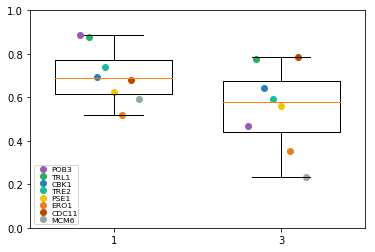

In [68]:
colors = ['#9B59B6', '#27AE60', '#2980B9', '#1ABC9C', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6']

pos_mod_list = [-0.4,-0.3,-0.2,-0.1,0, 0.1,0.2,0.3]


targets = ['POB3', 'TRL1', 'CBK1', 'TRE2', 'PSE1', 'ERO1', 'CDC11', 'MCM6']



for x in range(0, len(targets)):
    plt.plot((1+pos_mod_list[x]), model_coverage_dict[targets[x]], marker = 'o', linestyle = 'None', color = colors[x])
    
for x in range(0, len(targets)):    
    plt.plot((3+pos_mod_list[x]), np.percentile(random_coverage_dict[targets[x]],99), marker = 'o', linestyle = 'None', color = colors[x])
    
# for x in range(0, len(targets)):
#     print(model_coverage_dict[targets[x]], np.percentile(random_coverage_dict[targets[x]],99))
    
# for x in range(0, len(targets)):
#    plt.plot([(1+pos_mod_list[x]), (3+pos_mod_list[x])],
#             [model_coverage_dict[targets[x]], np.percentile(random_coverage_dict[targets[x]],99)],
#             marker = 'None', linestyle = '--', color = 'k')

    
plt.boxplot([list(model_coverage_dict.values()), 
             [np.percentile(x,99) for x in list(random_coverage_dict.values())]], widths = 1.4, positions = [1,3])


plt.legend(['POB3', 'TRL1', 'CBK1', 'TRE2', 'PSE1', 'ERO1', 'CDC11', 'MCM6'], loc='lower left', borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1, fontsize =7.8)


plt.ylim(0,1)
plt.xlim(0,4)

In [69]:
print(np.median(list(model_coverage_dict.values())))

0.6882406588238046


In [70]:
172061505*0.05

8603075.25

,VPS17_can_recov_1,VPS17_can_recov_2,average
toA|toA,0.001938,0.001909,0.001924
toA|toG,NaN,0.000764,NaN
toA|toT,0.151163,0.167621,0.159392
toG|toG,0.013566,0.009546,0.011556
toG|toT,0.020349,0.027873,0.024111
toG|wt,0.035853,0.032455,0.034154
toT|toA,0.009690,0.007637,0.008663
toT|toG,0.080426,0.071401,0.075914
toT|toT,0.584302,0.571974,0.578138
toT|wt,0.005814,0.010691,0.008253


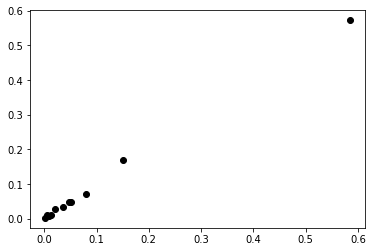

In [71]:
data_VPS17 = plot_corr_edited_alleles('VPS17', 'can_recov', 'black')


data_VPS17['average'] = (data_VPS17['VPS17_can_recov_1'] + data_VPS17['VPS17_can_recov_2'])/2

data_VPS17.head(25)


In [72]:
def genotype_proportions_wt_include(Sample_ID):
    
    genotype_freq = get_edit_and_coedit_rate(Sample_ID)
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    
    editable_sites = locus_edit_site_list_dict[locus]
    
    total_coverage = sum(genotype_freq.values())
    
    edit_allele_frac_dict = {}
    
    for allele in genotype_freq:
            
            edit_allele_frac_dict[allele] = genotype_freq[allele]/total_coverage
            
    
    
    
    return edit_allele_frac_dict


genotype_proportions_wt_include(119)

{'wt|toT': 0.043010752688172046,
 'wt|toG': 0.04659498207885305,
 'toT|toT': 0.5403225806451613,
 'wt|wt': 0.07526881720430108,
 'toA|toT': 0.13978494623655913,
 'toT|toG': 0.07437275985663082,
 'toT|wt': 0.005376344086021506,
 'toG|toT': 0.01881720430107527,
 'toG|toG': 0.012544802867383513,
 'toG|wt': 0.033154121863799284,
 'toT|toA': 0.008960573476702509,
 'toA|toA': 0.0017921146953405018}

In [73]:
def genotype_proportions_averaged(locus, timepoint):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == 'locus'
    select_samples_by_timepoint = sample_dataframe['Timepoint'] == timepoint
    
    select_samples = select_samples_by_locus & select_samples_by_target & select_samples_by_timepoint
    
    sample_pair = sorted(list(sample_dataframe[select_samples].index))
    
    allele_frac_1 = genotype_proportions_wt_include(sample_pair[0])
    allele_frac_2 = genotype_proportions_wt_include(sample_pair[1])
    
    allele_series_1 = pd.Series(allele_frac_1)
    allele_series_2 = pd.Series(allele_frac_2)

    combined_df = pd.DataFrame(dict((allele_series_1) = allele_series_1, allele_series_2 = allele_series_2))
    
    rename_dict = {'allele_series_1':str(locus+'_'+timepoint+'_1'),'allele_series_2':str(locus+'_'+timepoint+'_2')}
    
    combined_df.rename(columns=rename_dict, inplace=True)
    
    combined_df[(str(locus+'_'+timepoint+'_average'))] = (combined_df[str(locus+'_'+timepoint+'_1')] + combined_df[str(locus+'_'+timepoint+'_2')])/2
    
    return combined_df

genotype_proportions_averaged('VPS17','can_recov')

,VPS17_can_recov_1,VPS17_can_recov_2,VPS17_can_recov_average
toA|toA,0.001792,0.001729,0.001761
toA|toG,NaN,0.000692,NaN
toA|toT,0.139785,0.151798,0.145792
toG|toG,0.012545,0.008645,0.010595
toG|toT,0.018817,0.025242,0.022030
toG|wt,0.033154,0.029391,0.031273
toT|toA,0.008961,0.006916,0.007938
toT|toG,0.074373,0.064661,0.069517
toT|toT,0.540323,0.517981,0.529152
toT|wt,0.005376,0.009682,0.007529


In [74]:
data_VPS17 = genotype_proportions_averaged('YCL074W', 'can_recov')


data_VPS17['average'] = (data_VPS17['YCL074W_can_recov_1'] + data_VPS17['YCL074W_can_recov_2'])/2

data_VPS17.head(50)

,YCL074W_can_recov_1,YCL074W_can_recov_2,YCL074W_can_recov_average,average
toA|toA|toA,0.000750,0.001214,0.000982,0.000982
toA|toA|toT,NaN,0.000405,NaN,NaN
toA|toA|wt,0.170356,0.165049,0.167703,0.167703
toA|toC|wt,0.006004,0.007686,0.006845,0.006845
toA|toT|toT,0.000375,NaN,NaN,NaN
toA|toT|wt,0.022889,0.019013,0.020951,0.020951
toA|wt|toA,0.001876,0.001214,0.001545,0.001545
toA|wt|toC,0.000375,NaN,NaN,NaN
toA|wt|toT,0.000750,NaN,NaN,NaN
toA|wt|wt,0.022889,0.027508,0.025199,0.025199


In [75]:
data_VPS17 = genotype_proportions_averaged('TRE2', 'can_recov')


data_VPS17['average'] = (data_VPS17['TRE2_can_recov_1'] + data_VPS17['TRE2_can_recov_2'])/2

data_VPS17.head(50)

,TRE2_can_recov_1,TRE2_can_recov_2,TRE2_can_recov_average,average
toA|toA|toA,0.014404,0.013571,0.013988,0.013988
toA|toA|toT,0.000267,NaN,NaN,NaN
toA|toA|wt,0.000267,NaN,NaN,NaN
toA|toC|toA,0.000533,NaN,NaN,NaN
toA|toT|toA,0.001334,0.001429,0.001381,0.001381
toA|wt|toA,0.054948,0.049286,0.052117,0.052117
toA|wt|toC,0.001600,0.002857,0.002229,0.002229
toA|wt|toT,0.001867,0.003571,0.002719,0.002719
toA|wt|wt,0.007202,0.005357,0.006280,0.006280
toC|toA|toA,0.003734,0.007500,0.005617,0.005617


## Get fraction of mutant alleles predicted by our model

,ADE1_can_recov_1,ADE1_can_recov_2,averaged
toG,0.639850,0.657505,0.648678
toT,0.348062,0.329810,0.338936
toA,0.012088,0.012685,0.012387


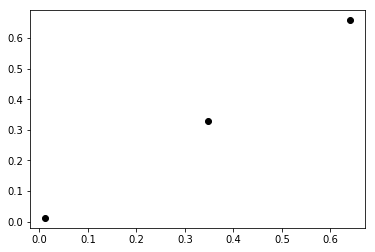

In [76]:
df_ADE1 = plot_corr_edited_alleles('ADE1', 'can_recov', 'black')

df_ADE1['averaged'] = (df_ADE1['ADE1_can_recov_1'] + df_ADE1['ADE1_can_recov_2'])/2

df_ADE1


,POB3_can_recov_1,POB3_can_recov_2,averaged
toA|toA|toA,0.014035,0.004525,0.009280
toA|toA|wt,0.035088,0.022624,0.028856
toA|toT|toA,0.003509,NaN,NaN
toA|toT|wt,NaN,0.004525,NaN
toA|wt|wt,0.007018,NaN,NaN
toT|toT|toA,0.003509,NaN,NaN
toT|wt|toA,NaN,0.004525,NaN
wt|toA|toA,0.014035,0.027149,0.020592
wt|toA|toT,0.003509,NaN,NaN
wt|toA|wt,0.452632,0.438914,0.445773


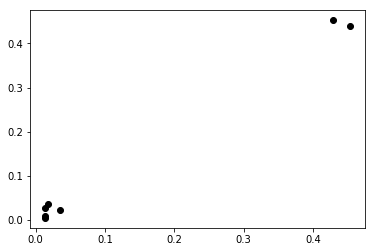

In [77]:
df_POB3 = plot_corr_edited_alleles('POB3', 'can_recov', 'black')

df_POB3['averaged'] = (df_POB3['POB3_can_recov_1'] + df_POB3['POB3_can_recov_2'])/2

df_POB3

,CBK1_can_recov_1,CBK1_can_recov_2,averaged
toA|toA,0.082288,0.076142,0.079215
toA|toC,0.011039,0.011168,0.011103
toA|toT,0.062720,0.070051,0.066385
toA|wt,0.117411,0.118782,0.118096
toC|toA,0.036126,0.038579,0.037353
toC|toC,0.018063,0.021320,0.019692
toC|toT,0.038635,0.047716,0.043175
toC|wt,0.416458,0.394924,0.405691
toT|toA,0.001505,NaN,NaN
toT|toC,0.000502,0.001015,0.000758


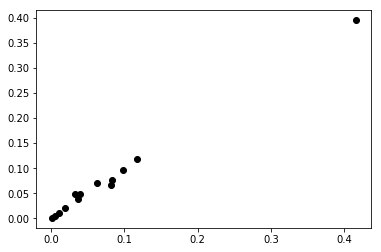

In [78]:
df_CBK1 = plot_corr_edited_alleles('CBK1', 'can_recov', 'black')

df_CBK1['averaged'] = (df_CBK1['CBK1_can_recov_1'] + df_CBK1['CBK1_can_recov_2'])/2

df_CBK1

,TRE2_can_recov_1,TRE2_can_recov_2,averaged
toA|toA|toA,0.016206,0.015224,0.015715
toA|toA|toT,0.000300,NaN,NaN
toA|toA|wt,0.000300,NaN,NaN
toA|toC|toA,0.000600,NaN,NaN
toA|toT|toA,0.001501,0.001603,0.001552
toA|wt|toA,0.061825,0.055288,0.058557
toA|wt|toC,0.001801,0.003205,0.002503
toA|wt|toT,0.002101,0.004006,0.003054
toA|wt|wt,0.008103,0.006010,0.007056
toC|toA|toA,0.004202,0.008413,0.006308


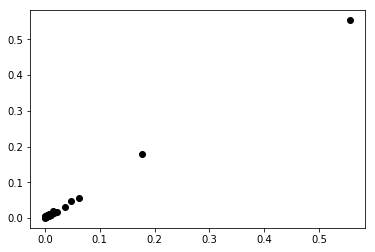

In [79]:
df_TRE2 = plot_corr_edited_alleles('TRE2', 'can_recov', 'black')

df_TRE2['averaged'] = (df_TRE2['TRE2_can_recov_1'] + df_TRE2['TRE2_can_recov_2'])/2

df_TRE2

,TRL1_can_recov_1,TRL1_can_recov_2,averaged
toA|toA|toA,0.006369,0.003968,0.005169
toA|toA|toT,0.002123,NaN,NaN
toA|toA|wt,0.008493,NaN,NaN
toA|toC|wt,0.002123,0.003968,0.003046
toA|toT|wt,0.002123,NaN,NaN
toA|wt|wt,0.019108,0.031746,0.025427
toC|toA|toA,0.008493,0.007937,0.008215
toC|toA|wt,0.006369,0.027778,0.017074
toC|toC|wt,0.002123,NaN,NaN
toC|wt|wt,0.031847,0.047619,0.039733


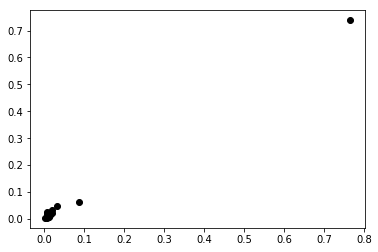

In [80]:
df_TRL1 = plot_corr_edited_alleles('TRL1', 'can_recov', 'black')

df_TRL1['averaged'] = (df_TRL1['TRL1_can_recov_1'] + df_TRL1['TRL1_can_recov_2'])/2

df_TRL1

,PSE1_can_recov_1,PSE1_can_recov_2,averaged
toA|toA|toA,0.000494,0.001294,0.000894
toA|toA|toT,0.000494,NaN,NaN
toA|toA|wt,0.000494,0.001294,0.000894
toA|toG|wt,0.000494,NaN,NaN
toA|toT|toA,0.003955,0.006468,0.005211
toA|toT|toG,0.000989,0.002587,0.001788
toA|toT|toT,0.009886,0.016818,0.013352
toA|toT|wt,0.044488,0.054334,0.049411
toA|wt|toA,0.000989,0.003881,0.002435
toA|wt|toG,0.002472,0.005175,0.003823


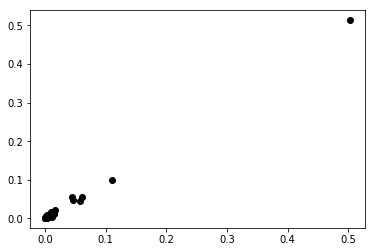

In [81]:
df_PSE1 = plot_corr_edited_alleles('PSE1', 'can_recov', 'black')

df_PSE1['averaged'] = (df_PSE1['PSE1_can_recov_1'] + df_PSE1['PSE1_can_recov_2'])/2

df_PSE1

,ERO1_Plating_1,ERO1_Plating_2,averaged
toA|toG|wt,NaN,0.000700,NaN
toA|toT|toG,0.001447,NaN,NaN
toA|toT|toT,0.001447,0.007703,0.004575
toA|toT|wt,0.001447,0.001401,0.001424
toA|wt|toG,0.011577,0.003501,0.007539
toA|wt|wt,0.005789,0.023810,0.014799
toG|toA|toT,NaN,0.000700,NaN
toG|toG|wt,0.007236,0.002801,0.005019
toG|toT|toG,0.002894,0.000700,0.001797
toG|toT|toT,0.004342,0.001401,0.002871


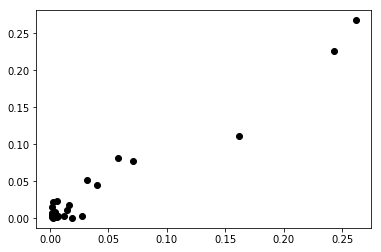

In [82]:
df_ERO1 = plot_corr_edited_alleles('ERO1', 'Plating', 'black')

df_ERO1['averaged'] = (df_ERO1['ERO1_Plating_1'] + df_ERO1['ERO1_Plating_2'])/2

df_ERO1

,CDC11_can_recov_1,CDC11_can_recov_2,averaged
toA|toA,0.091503,0.097778,0.094641
toA|toC,0.004357,0.005926,0.005142
toA|toT,0.004357,NaN,NaN
toA|wt,0.254902,0.223704,0.239303
toC|toA,0.043573,0.042963,0.043268
toC|toC,0.002179,0.001481,0.001830
toC|toT,NaN,0.004444,NaN
toC|wt,0.431373,0.453333,0.442353
toT|toA,0.015251,0.011852,0.013551
toT|toC,0.002179,0.005926,0.004052


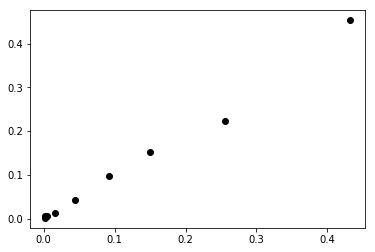

In [83]:
df_CDC11 = plot_corr_edited_alleles('CDC11', 'can_recov', 'black')

df_CDC11['averaged'] = (df_CDC11['CDC11_can_recov_1'] + df_CDC11['CDC11_can_recov_2'])/2

df_CDC11

,MCM6_can_recov_1,MCM6_can_recov_2,averaged
toA|toA|toT|wt,NaN,0.000917,NaN
toA|toG|toA|wt,NaN,0.000917,NaN
toA|toG|wt|wt,0.002592,0.005505,0.004048
toA|toT|toT|wt,0.002304,0.002752,0.002528
toA|toT|wt|toG,0.000288,NaN,NaN
toA|toT|wt|toT,0.000576,NaN,NaN
toA|toT|wt|wt,0.006048,0.007339,0.006694
toA|wt|toA|wt,0.000288,NaN,NaN
toA|wt|toG|wt,0.000288,NaN,NaN
toA|wt|wt|wt,0.000288,NaN,NaN


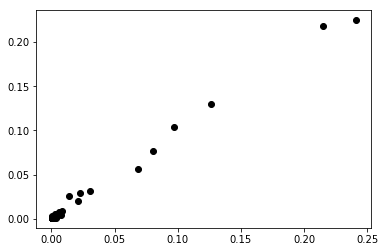

In [84]:
df_MCM6 = plot_corr_edited_alleles('MCM6', 'can_recov', 'black')

df_MCM6['averaged'] = (df_MCM6['MCM6_can_recov_1'] + df_MCM6['MCM6_can_recov_2'])/2

df_MCM6.head(100)

0.9907139157823533

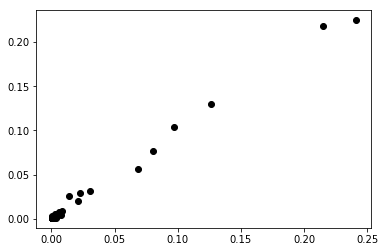

In [85]:
df_MCM6 = plot_corr_edited_alleles('MCM6', 'can_recov', 'black')

df_MCM6['averaged'] = (df_MCM6['MCM6_can_recov_1'] + df_MCM6['MCM6_can_recov_2'])/2

df_MCM6['averaged'].sum()

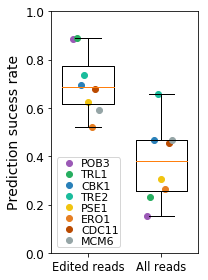

In [86]:
plt.figure(figsize = (3,4))

colors = ['#9B59B6', '#27AE60', '#2980B9', '#1ABC9C', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6']

pred_success_list_chip =[x/100 for x in [88.6, 88.9, 69.5, 73.7, 62.5, 52, 68, 59]]

pred_success_frac_reads = [x/100 for x in [(88.6*0.17), (88.9*0.26), (69.5*0.67), (73.7*0.89), (62.5*0.49), (52*0.51), (68*0.67), (59*0.79)]]

pos_mod_list = [-0.4,-0.3,-0.2,-0.1,0, 0.1,0.2,0.3]



for x in range(0, len(pred_success_list_chip)):
    plt.plot((1+pos_mod_list[x]), pred_success_list_chip[x], marker = 'o', linestyle = 'None', color = colors[x])
    
for x in range(0, len(pred_success_list_chip)):    
    plt.plot((3+pos_mod_list[x]), pred_success_frac_reads[x], marker = 'o', linestyle = 'None', color = colors[x])

    
plt.boxplot([pred_success_list_chip, pred_success_frac_reads], widths = 1.4, positions = [1,3])


plt.legend(['POB3', 'TRL1', 'CBK1', 'TRE2', 'PSE1', 'ERO1', 'CDC11', 'MCM6'], loc='lower left', borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1, fontsize = 11)

plt.ylim(0,1)
plt.xlim(0,4)


plt.ylabel('Prediction sucess rate', fontsize = 14)
plt.xticks([1,3], ['Edited reads','All reads'], fontsize =11.5)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('./prediction.png', format='png', dpi=600)

In [87]:
df_dict_recov = {}

for locus in list(sample_dataframe.Locus.unique()):
    
    print(locus)
    
    if locus == 'ERO1':
        
        out_df = genotype_proportions_averaged(locus,'Plating')
        
        df_dict_recov[locus] = out_df
        
    else:
        
        out_df = genotype_proportions_averaged(locus,'can_recov')
        
        df_dict_recov[locus] = out_df
        
print(df_dict_recov.keys())

ADE1
POB3
CBK1
TRE2
TRL1
PSE1
ERO1
CDC11
MCM6
SES1
YCL074W
VPS17
dict_keys(['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17'])


## check the coverage of the aproximation caused by NaN removal

In [88]:
for df in df_dict_recov.keys():
    
    data = df_dict_recov[df]
    
    sum_list = []
    
    for col in list(data.columns):
        
        sum_list.append(data[col].sum())
        
    print(df, sum_list)
    

ADE1 [0.9999999999999999, 1.0, 0.9999999999999998]
POB3 [1.0, 0.9999999999999999, 0.9973343524578416]
CBK1 [1.0, 1.0, 0.9984720542723042]
TRE2 [1.0, 1.0, 0.9981735605685326]
TRL1 [1.0, 1.0, 0.9958060071645081]
PSE1 [1.0, 1.0, 0.9983918852053438]
ERO1 [1.0, 1.0, 0.9979735157454792]
CDC11 [1.0, 1.0, 0.9970389739394647]
MCM6 [1.0, 1.0, 0.9925977990118702]
SES1 [1.0, 1.0, 0.9976744186046511]
YCL074W [1.0, 1.0, 0.997083204308518]
VPS17 [1.0, 0.9999999999999999, 0.9991355463347166]


Removing the NaNs is not impactful, biggest loss id 0.75% of total genotypes, but on average prob lower than 0.30% loss. Acceptable to calculate ratios downstream.

In [89]:
nt_dict_of_dict = {}


for Sample_ID in [1,11,21,31,41,51,61,71,81,91,101,111]:
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    
    guide_seq = sample_dataframe.loc[Sample_ID]['gRNA_seq']
    
    nt_list = [x for x in guide_seq]
    
    guide_pos_nt_dict = {}
    
    for nt in range(0,len(nt_list)):
        
        guide_pos_nt_dict[(nt+1)] = nt_list[nt]
        
    nt_dict_of_dict[locus] = guide_pos_nt_dict
        
guide_nt_pos_df = pd.DataFrame.from_dict(nt_dict_of_dict, orient='index')

guide_nt_pos_df = guide_nt_pos_df.reindex(['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17'], copy=False)

transform_dict = {'G':0,
                  'T':1,
                  'C':2,
                  'A':3}

def convert_to_num(x):
    
    if x=='G':
        return 1
    if x=='T':
        return 2
    if x=='C':
        return 3
    if x=='A':
        return 4
    
def convert_to_annot(x):
    
    if x in ['A', 'T', 'G']:
        return ''
    if x == 'C':
        return 'C'
    


guide_nt_pos_num_vals = guide_nt_pos_df[guide_nt_pos_df.columns].applymap(convert_to_num)

guide_nt_pos_num_vals[10].replace(to_replace = [1,2,3,4], value=5, inplace=True)

guide_nt_annnot = guide_nt_pos_df[guide_nt_pos_df.columns].applymap(convert_to_annot)
guide_nt_annnot[10].replace(to_replace = 'C', value='', inplace=True)
guide_nt_annnot[9].replace(to_replace = 'C', value='', inplace=True)
guide_nt_annnot[8].replace(to_replace = 'C', value='', inplace=True)



guide_nt_pos_num_vals.head(12)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ADE1,1,2,3,4,4,2,2,4,3,5,4,4,1,4,3,2,1,4,4,3
POB3,3,4,2,3,2,3,2,4,3,5,4,4,2,2,3,1,2,3,4,3
CBK1,1,4,3,2,3,2,4,2,4,5,4,4,2,4,2,2,1,1,3,3
TRE2,2,4,2,3,3,2,3,4,1,5,2,1,2,2,2,3,4,1,2,2
TRL1,3,3,4,4,3,2,4,2,2,5,2,2,3,2,3,4,3,4,1,2
PSE1,1,4,2,3,3,3,4,4,4,5,4,2,3,3,2,1,1,4,2,4
ERO1,2,2,3,4,3,3,4,4,4,5,4,4,3,4,2,4,2,2,1,2
CDC11,3,4,3,4,1,1,1,4,2,5,4,2,1,2,2,4,4,3,2,4
MCM6,2,3,2,3,3,1,3,3,4,5,3,4,2,3,1,2,3,1,4,2
SES1,3,4,4,3,3,4,4,2,2,5,4,2,3,1,4,4,1,4,2,4


In [90]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import colorConverter

color_list = ((0.75, 0, 0.75, 1), (1.0, 0.0, 0.0,1), (0.0, 0.0, 1.0, 1), (0, 1.0, 0,1))

color_list = ((0.5019607843137255, 0.0, 0.5019607843137255, 0.4), (1.0, 0.0, 0.0,0.4), (0.0, 0.0, 1, 0.6), (0.0, 0.5019607843137255, 0.0, 0.4),
             (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.4))


# magenta red blue green

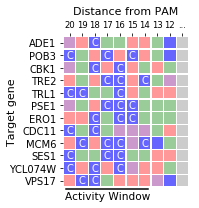

In [91]:
plt.figure(figsize = (5,3))


fig  = sns.heatmap(guide_nt_pos_num_vals[guide_nt_pos_num_vals.columns[0:10]], cmap=ListedColormap(color_list), 
                   annot=guide_nt_annnot[guide_nt_annnot.columns[0:10]], fmt="", cbar=False, square=True, linewidths=0.15)





fig.xaxis.tick_top()

plt.xticks([x+0.5 for x in range(0,10)], [20,19,18,17,16,15,14,13,12,'...'], fontsize=8.5)

plt.title('Distance from PAM', fontsize =11)
plt.xlabel('Activity Window', horizontalalignment='left', x=0.015, fontsize=10.5)
plt.axhline(12.15,0.025,0.675, color='black', clip_on=False)

plt.ylabel('Target gene', fontsize =11, labelpad = -8)

plt.axvline(7, color='white')
plt.tight_layout()

plt.savefig('./guide_seq_heatmap.svg', format = 'svg', dpi =600)

In [92]:
[x for x in range(20,0,-1)]

[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [93]:
colorConverter.to_rgba('grey')

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 1.0)

0.2896224283991701 0.5504227079179058 0.9329347151509941 0.05390435305424664
WilcoxonResult(statistic=112.0, pvalue=0.01319416986541395)
WilcoxonResult(statistic=41.0, pvalue=8.187753439649276e-05)
WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


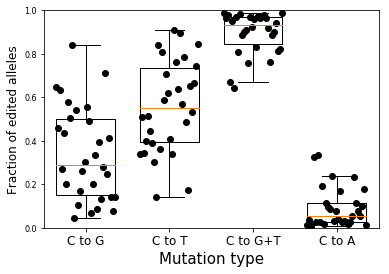

In [94]:
import pickle as pl

panel_D_data = pl.load(open('./pickled_objects/fig2_panel_D_data.pickle', 'rb'))

to_G_list = panel_D_data[0]
to_T_list = panel_D_data[1]
ToGorT = panel_D_data[2]
to_A_list = panel_D_data[3]


plt.boxplot([to_G_list, to_T_list, ToGorT , to_A_list], positions = [1,2,3,4], widths = 0.7, showfliers=False)

data_point_x = list(np.arange(0.65, 1.35,0.024))

for x in data_point_x:
    
    plt.plot(x, to_G_list[data_point_x.index(x)], 'ko')
    plt.plot(x+1, to_T_list[data_point_x.index(x)], 'ko')
    plt.plot(x+2, ToGorT[data_point_x.index(x)], 'ko')
    plt.plot(x+3, to_A_list[data_point_x.index(x)], 'ko')
    
plt.ylim(0,1)
plt.ylabel('Fraction of edited alleles', fontsize = 12)
plt.yticks(fontsize=8)

plt.xticks([1,2,3,4], ['C to G', 'C to T', 'C to G+T', 'C to A'], fontsize = 12)

plt.xlabel('Mutation type', fontsize = 15)

print(np.median(to_G_list), np.median(to_T_list), np.median(ToGorT), np.median(to_A_list))



print(scipy.stats.wilcoxon(to_G_list, to_T_list))
print(scipy.stats.wilcoxon(to_G_list, to_A_list))
print(scipy.stats.wilcoxon(to_T_list, to_A_list))



## rank v rank plot test

In [95]:
data = pd.DataFrame.from_dict({ 1:{1:9,2:1,3:0,4:0},
                                2:{1:1,2:7,3:2,4:0},
                                3:{1:0,2:2,3:5,4:0},
                                4:{1:0,2:0,3:0,4:1}})
data_density = data/data.sum().sum()
print(data.sum().sum())
print(data_density)

#sns.heatmap(data_density, cmap='viridis', square=True)

28
          1         2         3         4
1  0.321429  0.035714  0.000000  0.000000
2  0.035714  0.250000  0.071429  0.000000
3  0.000000  0.071429  0.178571  0.000000
4  0.000000  0.000000  0.000000  0.035714


In [96]:
exper_diagonal = data_density.loc[1][1]+data_density.loc[2][2]+data_density.loc[3][3]+data_density.loc[4][4]

exper_diagonal

0.7857142857142857

In [97]:
diag_val_list = []

val_above_obs = 0

for seed in range(0,1000000):
    random.seed(seed)

    s1 = [1,2,3]
    s2 = [1,2]
    s3 = [1,2,3]
    s4 = [1,2,3]
    s5 = [1,2,3]
    s6 = [1,2,3]
    s7 = [1,2,3]
    s8 = [1,2]
    s9 = [1,2,3,4]
    s10 = [1,2]

    site_list = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]

    out_matrix = { 1:{1:0,2:0,3:0,4:0},
                   2:{1:0,2:0,3:0,4:0},
                   3:{1:0,2:0,3:0,4:0},
                   4:{1:0,2:0,3:0,4:0} }

    for site in site_list:

        random.shuffle(site)

        for rank in site:

            expected_rank = rank

            observed_rank = (site.index(rank))+1

            out_matrix[expected_rank][observed_rank]+=1

    iter_df = pd.DataFrame.from_dict(out_matrix)
    iter_density =iter_df/iter_df.sum().sum()

    observed_diagonal = iter_density.loc[1][1]+iter_density.loc[2][2]+iter_density.loc[3][3]+iter_density.loc[4][4]
    diag_val_list.append(observed_diagonal)
    
    if observed_diagonal >= exper_diagonal:
        val_above_obs+=1
        
val_above_obs_ratio = val_above_obs/1000000
print(val_above_obs_ratio)

0.000374


In [98]:
print(iter_df.sum().sum())

28


1000000
374 0.000374


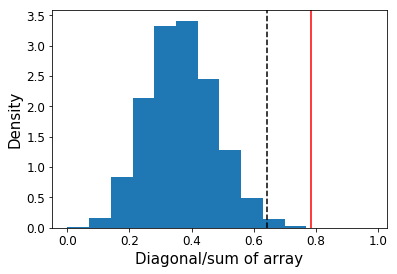

In [99]:
bins = [x for x in np.arange(0,1,0.07)]

plt.hist(diag_val_list, bins=bins, density=True)
print(len(diag_val_list))

plt.axvline(exper_diagonal, color='r')

print(val_above_obs, val_above_obs/1000000)

plt.xlabel('Diagonal/sum of array', fontsize=15)
plt.ylabel('Density', fontsize = 15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.axvline(np.percentile(diag_val_list, 99), linestyle='--', color ='k')

In [100]:
l1 = [1,2,3]
print(l1)
random.shuffle(l1)
print(l1)

[1, 2, 3]
[1, 2, 3]


## Assemble figure 2

## with null model of read coverage by genotype

['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
['T0_1', 'T6_1', 'T12_1', 'Plating_1', 'can_recov_1']
bar_coord: 133


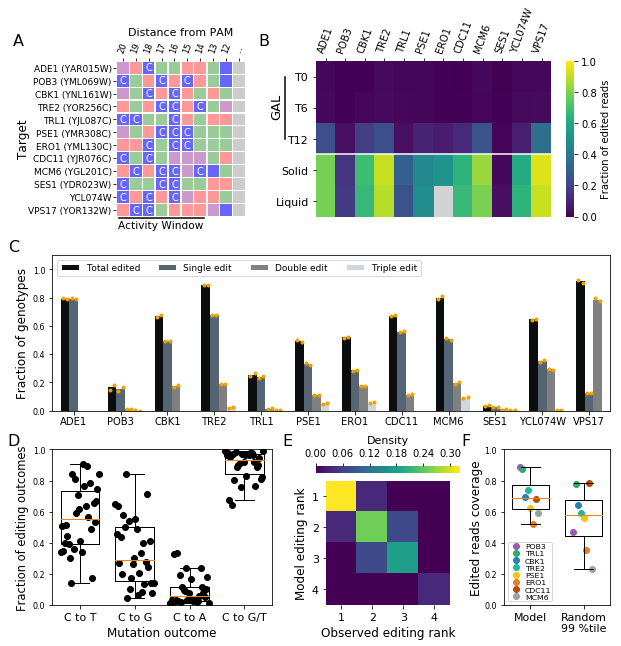

In [106]:
fig2 = plt.figure(figsize = (10,10))
gs = fig2.add_gridspec(3, 15, hspace=0.25)

################################################
f2_ax1 = fig2.add_subplot(gs[0, 1:6])

fig  = sns.heatmap(guide_nt_pos_num_vals[guide_nt_pos_num_vals.columns[0:10]], cmap=ListedColormap(color_list), 
                   annot=guide_nt_annnot[guide_nt_annnot.columns[0:10]], fmt="", cbar=False, linewidths=0.15, square=True)




fig.xaxis.tick_top()

plt.xticks([x+0.5 for x in range(0,10)], [20,19,18,17,16,15,14,13,12,'...'], fontsize=8.5, rotation=70)

plt.yticks([x+0.5 for x in range(0,12)],['ADE1 (YAR015W)' , 'POB3 (YML069W)', 'CBK1 (YNL161W)', 'TRE2 (YOR256C)', 'TRL1 (YJL087C)', 'PSE1 (YMR308C)',
                                         'ERO1 (YML130C)', 'CDC11 (YJR076C)', 'MCM6 (YGL201C)', 'SES1 (YDR023W)','YCL074W', 'VPS17 (YOR132W)' ], 
           fontsize=9)

plt.title('Distance from PAM', fontsize =11)
plt.xlabel('Activity Window', horizontalalignment='left', x=0.015, fontsize=10.5)
plt.axhline(12.15,0.025,0.675, color='black', clip_on=False)

plt.ylabel('Target', fontsize =12, labelpad = -2)
plt.tick_params(axis='y', pad=1)

plt.axvline(7, color='white')


plt.text(-0.795, 1.1,'A', transform = f2_ax1.transAxes, fontsize=16)

###############################################
f2_ax2 = fig2.add_subplot(gs[0, 7:16], anchor='N')


mask = np.isnan(edit_rate_ordered)
fig = sns.heatmap(edit_rate_ordered, cmap='viridis', vmin = 0, vmax =1, cbar_kws = {'label':'Fraction of edited reads', "shrink": 1}, 
                  mask = mask)

fig.set_facecolor('lightgrey')

fig.xaxis.tick_top()


plt.axhline(3, color='white')

plt.yticks([0.5,1.5,2.5,3.5,4.5],['T0', 'T6', 'T12', 'Solid', 'Liquid'], rotation = 0, fontsize=11)

plt.axvline(-1.55, 0.5, 0.9 ,color='black', clip_on=False)

plt.text(-2.3, 1.35, 'GAL', rotation=90, fontsize=13)

plt.xticks(rotation = 70)

plt.text(1.1, 1.1,'B', transform = f2_ax1.transAxes, fontsize=16)

##############################################
f2_ax3 = fig2.add_subplot(gs[1, :])

bar_coord = 1

colors = ['#0B0D0E', '#566573', '#808080', '#D1D6DC', 'red']

ticks_coord = []

for locus in list(sample_dataframe.Locus.unique()):
    
    edit_vals = get_coedit_number_abundance(locus)
    
    bar_height_list = edit_vals[0]
    rep1_data = edit_vals[1]
    rep2_data = edit_vals[2]
    
    for pos in [0,1,2,3]:
        
        if rep1_data[pos] != 0:
            plt.plot(bar_coord-0.5, rep1_data[pos], color='#EFA300', marker='o', linestyle='none', ms=3)
            
        if rep2_data[pos] != 0:
            plt.plot(bar_coord+0.5, rep2_data[pos], color='#EFA300', marker='o', linestyle='none', ms=3)

        plt.bar(bar_coord, height=bar_height_list[pos], width=2, align = 'center', color = colors[pos])
        
        
        if pos == 1:
            
            ticks_coord.append(bar_coord)
        
        bar_coord+=2
        
    bar_coord += 3
        
        
plt.xticks(ticks_coord, list(sample_dataframe.Locus.unique()))
plt.tick_params(axis='x', pad=2)
plt.yticks(fontsize=8)
        
plt.ylabel('Fraction of genotypes', fontsize = 12)

plt.xlim(-2,129)
print('bar_coord:', bar_coord)

from matplotlib.patches import Patch

legend_elems =  [Patch(facecolor='#0B0D0E', edgecolor='white', label='Total edited'),
                 Patch(facecolor='#566573', edgecolor='white', label='Single edit'),
                 Patch(facecolor='#808080', edgecolor='white', label='Double edit'),
                 Patch(facecolor='#D1D6DC', edgecolor='white', label='Triple edit')]

    
plt.legend(handles = legend_elems, ncol =4, loc = 'upper left', fontsize=9)
    
    
    
plt.ylim(0, 1.1)

plt.text(-0.08, 1.025,'C', transform = f2_ax3.transAxes, fontsize=16)


###############################################
f2_ax4 = fig2.add_subplot(gs[2, 0:6])

panel_D_data = pl.load(open('./pickled_objects/fig2_panel_D_data.pickle', 'rb'))

to_G_list = panel_D_data[0]
to_T_list = panel_D_data[1]
ToGorT = panel_D_data[2]
to_A_list = panel_D_data[3]


plt.boxplot([to_T_list, to_G_list, to_A_list, ToGorT], positions = [1,2,3,4], widths = 0.7, showfliers=False)

data_point_x = list(np.arange(0.65, 1.35,0.024))

for x in data_point_x:
    
    plt.plot(x+1, to_G_list[data_point_x.index(x)], 'ko')
    plt.plot(x, to_T_list[data_point_x.index(x)], 'ko')
    plt.plot(x+2, to_A_list[data_point_x.index(x)], 'ko')
    plt.plot(x+3, ToGorT[data_point_x.index(x)], 'ko')
    
plt.ylim(0,1)
plt.ylabel('Fraction of editing outcomes', fontsize = 11.5)
plt.yticks(fontsize=8)

plt.xticks([1,2,3,4], ['C to T', 'C to G',  'C to A', 'C to G/T'], fontsize = 11)

plt.xlabel('Mutation outcome', fontsize = 12)

plt.text(-0.206, 1.03,'D', transform = f2_ax4.transAxes, fontsize=16)


#############################################################
f2_ax5 = fig2.add_subplot(gs[2, 7:11])


sns.heatmap(data_density, cmap='viridis', square=True, cbar_kws = {'label':'Density', "shrink": 1, 'use_gridspec':False, 'location':"top"})

cbar = f2_ax5.collections[0].colorbar
cbar.set_label('Density', labelpad=5, fontsize=11)

plt.xlabel('Observed editing rank', fontsize=12)
plt.ylabel('Model editing rank', fontsize=12)

plt.yticks(fontsize=11, rotation=0)
plt.xticks(fontsize=11)

plt.text(-0.35, 1.285,'E', transform = f2_ax5.transAxes, fontsize=16)


############################################################
f2_ax6 = fig2.add_subplot(gs[2, 12:16])


plt.yticks(fontsize=8)


colors = ['#9B59B6', '#27AE60', '#2980B9', '#1ABC9C', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6']


pos_mod_list = [-0.4,-0.3,-0.2,-0.1,0, 0.1,0.2,0.3]



for x in range(0, len(targets)):
    plt.plot((1+pos_mod_list[x]), model_coverage_dict[targets[x]], marker = 'o', linestyle = 'None', color = colors[x])
    
for x in range(0, len(targets)):    
    plt.plot((3+pos_mod_list[x]), np.percentile(random_coverage_dict[targets[x]],99), marker = 'o', linestyle = 'None', color = colors[x])
    
# for x in range(0, len(targets)):
#     print(model_coverage_dict[targets[x]], np.percentile(random_coverage_dict[targets[x]],99))
    
# for x in range(0, len(targets)):
#    plt.plot([(1+pos_mod_list[x]), (3+pos_mod_list[x])],
#             [model_coverage_dict[targets[x]], np.percentile(random_coverage_dict[targets[x]],99)],
#             marker = 'None', linestyle = '--', color = 'k')

    
plt.boxplot([list(model_coverage_dict.values()), 
             [np.percentile(x,99) for x in list(random_coverage_dict.values())]], widths = 1.4, positions = [1,3])


plt.legend(['POB3', 'TRL1', 'CBK1', 'TRE2', 'PSE1', 'ERO1', 'CDC11', 'MCM6'], loc='lower left', borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1, fontsize =7.8)

plt.ylim(0,1)
plt.xlim(0,4)


plt.ylabel('Edited reads coverage', fontsize = 12, labelpad =1)
plt.xticks([1,3], ['Model','Random\n99 %tile'], fontsize =11)

plt.text(-0.4, 1.03,'F', transform = f2_ax6.transAxes, fontsize=16)


plt.savefig('./figure1_19032020.pdf', format = 'pdf', dpi=600)
